## Importeer bibliotheken

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import os

## Laad de geveltekening in
De afbeelding wordt geladen met alpha-kanaal als dat beschikbaar is. De afmetingen worden weergegeven

In [2]:
# === Afbeelding inladen ===
img = cv2.imread(r"Data_nest_uitgesneden\half_vrijstaand_type_e (1).png")
# img = cv2.imread(r"Data_nest_uitgesneden\halfvrijestaande (4).png")  # Alternatieve testafbeelding

print(f"Afbeelding geladen. Formaat: {img.shape}")

Afbeelding geladen. Formaat: (765, 1194, 3)


## Toon de originele geveltekening

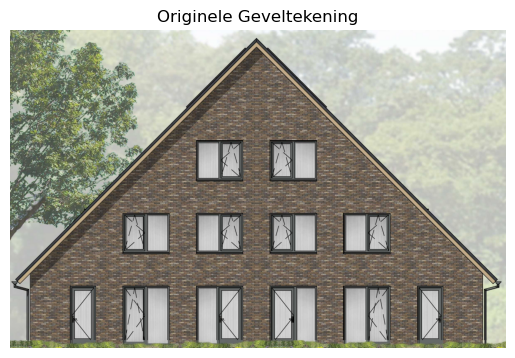

In [3]:
# === Zet BGR om naar RGB voor correcte weergave met matplotlib ===
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === Toon de originele afbeelding ===
plt.imshow(img_rgb)
plt.title("Originele Geveltekening")
plt.axis("off")
plt.show()

## Zet afbeelding om naar grijswaarden

Voor veel beeldverwerkingstaken zoals randdetectie is kleurinformatie niet nodig. 
Door de afbeelding om te zetten naar grijswaarden:

- Verminderen we de hoeveelheid gegevens (van 3 kanalen naar 1).
- Worden randen en vormen duidelijker.
- Gaat de verwerking sneller en efficiënter.

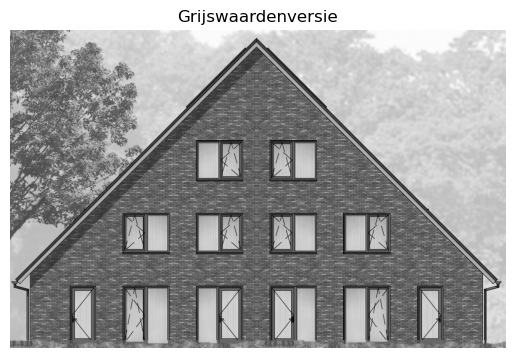

In [4]:
# === Converteer afbeelding naar grijswaarden ===
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# === Toon de grijswaardenafbeelding ===
plt.imshow(gray, cmap="gray")
plt.title("Grijswaardenversie")
plt.axis("off")
plt.show()

## Gaussian Blur toepassen om ruis te verminderen

We gebruiken een Gaussian Blur om het beeld te vervagen en kleine ruis of details te onderdrukken. 
Dit zorgt ervoor dat de randdetectie robuuster en minder gevoelig is voor kleine afwijkingen.

De gekozen parameters voor de kernelgrootte `(13, 13)` en standaarddeviatie `2.2` zijn bepaald op basis van visuele inspectie. 
Er is geen automatische methode toegepast; we hebben geëvalueerd wat subjectief het beste resultaat geeft.

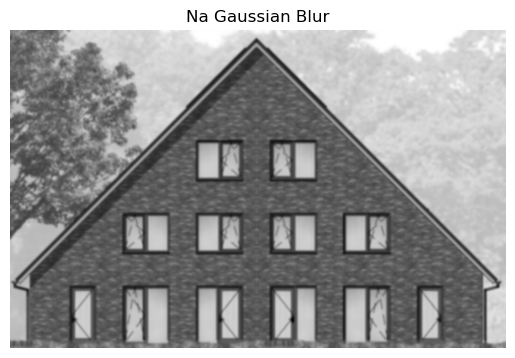

In [5]:
# === Pas Gaussian Blur toe op de grijswaardenafbeelding ===
blur = cv2.GaussianBlur(gray, (13, 13), 2.2)

# === Toon de afbeelding na Gaussian Blur ===
plt.imshow(blur, cmap="gray")
plt.title("Na Gaussian Blur")
plt.axis("off")
plt.show()

## Voer Canny-randdetectie uit

We gebruiken het Canny-algoritme om randen te detecteren in het vervaagde beeld. Canny werkt in meerdere stappen:

- Het berekent de gradiënten (sterke helderheidsveranderingen) in het beeld.
- Alleen overgangen die binnen twee drempelwaarden vallen, worden als randen herkend.
- Dankzij deze aanpak is Canny effectief in het vinden van echte randen en relatief ongevoelig voor ruis — vooral na het toepassen van een Gaussian Blur.

De gebruikte drempelwaarden `(50, 150)` zijn gekozen op basis van visuele inspectie. Er is geen automatische optimalisatie toegepast; we hebben geëvalueerd wat subjectief het meest betrouwbare resultaat geeft voor dit type afbeelding.

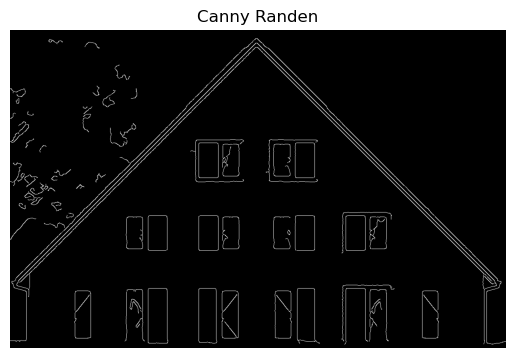

In [6]:
# === Pas Canny edge-detectie toe op de vervaagde afbeelding ===
edges = cv2.Canny(blur, 50, 150)

# === Toon de gedetecteerde randen ===
plt.imshow(edges, cmap="gray")
plt.title("Canny Randen")
plt.axis("off")
plt.show()

## Het resultaat

We zien dat de ramen onderbroken en niet gesloten zijn door de vervaging in de foto. Hierdoor ontstaan er gaten in de randen die het detectieproces verstoren. Om deze gaten te dichten en de randen te versterken, passen we een morfologische sluitingsbewerking toe. Dit helpt om de structuur van de randen te verbeteren en maakt de segmentatie nauwkeuriger.


## Voer morfologische sluiting uit

Deze stap helpt om onderbroken randen te verbinden en kleine gaten te vullen

#### Effect van morfologische sluiting

- **Doel:** Vult gaten en verwijdert inkepingen in randen.
- **Kernel:** `np.ones((30, 30), np.uint8)`  
  Een matrix van 30×30 enen (vierkant structuurelement).
- **Grootte-effect:**  
  - Grote kernels vullen grotere gaten.  
  - Kleine kernels behouden details.


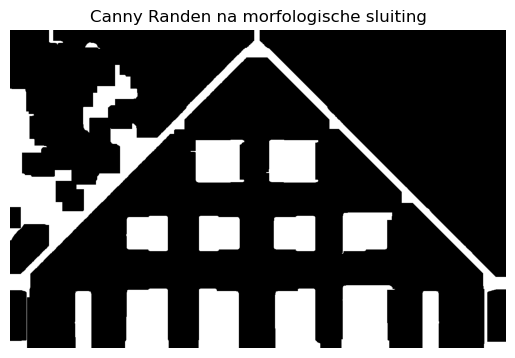

In [7]:
# === Morfologische sluiting om gaten in randen te vullen ===
kernel = np.ones((50, 50), np.uint8)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# === Toon resultaat na morfologische sluiting ===
plt.imshow(closed, cmap="gray")
plt.title("Canny Randen na morfologische sluiting")
plt.axis("off")
plt.show()

## Het resultaat

We kunnen visueel zien dat het resultaat is verbeterd: ramen en deuren zijn duidelijk van elkaar te onderscheiden, evenals het hele huis.  
De gevel is beter en scherper zichtbaar geworden. De morfologische sluiting levert een goed resultaat op voor deze gevel.

Nu is het tijd om de daadwerkelijke detectie uit te voeren en het eindresultaat te beoordelen.

## Contourdetectie en objectclassificatie
We vinden de contouren van objecten in de afbeelding (zoals ramen en deuren), bepalen hun grootte en aspect ratio en classificeren ze. Objecten worden met rechthoeken en labels op de afbeelding getekend.

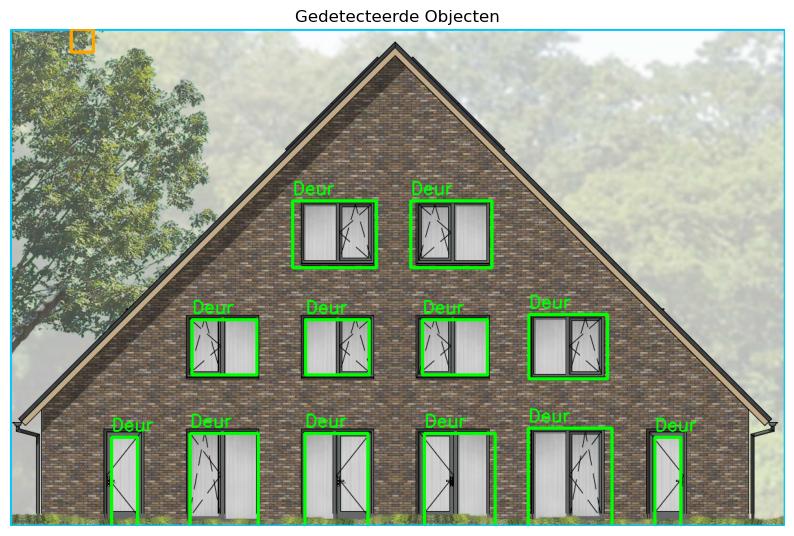

In [8]:
# === Vind contouren in het gesloten beeld ===
contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# === Kopieer RGB-afbeelding om objecten op te tekenen ===
output_img = img_rgb.copy()

# === Bepaal grootste contour op basis van oppervlak ===
largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])
largest_area = cv2.boundingRect(largest_cnt)[2] * cv2.boundingRect(largest_cnt)[3]

# === Classificatieparameters ===
min_area_deur = 5000
max_area_deur = 20000
min_area_raam = 1000
max_area_raam = 5000

detected_objects = []

# === Doorloop alle contouren en classificeer ===
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0

    if np.array_equal(cnt, largest_cnt):
        label = "Huis"
        color = (0, 200, 255)
    elif min_area_deur < area < max_area_deur:
        label = "Deur"
        color = (0, 255, 0)
    elif min_area_raam < area < max_area_raam:
        label = "Raam"
        color = (255, 165, 0)
    else:
        continue  # negeer contouren buiten classificatiecriteria

    # Teken bounding box en label
    cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
    cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# === Toon eindresultaat ===
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Gedetecteerde Objecten")
plt.axis("off")
plt.show()

## Conclusie

De detectie van de gevel is correct uitgevoerd en geeft een goed resultaat voor de afbeelding "`half_vrijstaand_type_e (1).png`".  
Er zijn enkele kleine fouten bij het onderscheiden van ramen en deuren; soms wordt een raam als deur beschouwd. Dit is echter acceptabel zolang het model alle objectvormen kan vinden.

Bij het uitvoeren van de detectie op een andere gevel zien we dat het model een slechter resultaat oplevert. Dit is duidelijk te zien aan de hand van de afbeelding "`half_vrijstaand_type_e (2).png`".

De volgende cel legt uit wat er misgaat en waarom dit gebeurt.


## Voorbeeld  
### Effect van morfologische sluiting op vormdetectie

In dit voorbeeld maken we vier eenvoudige vormen om te illustreren hoe morfologische sluiting werkt.  
We doen dit om het effect begrijpelijk te maken, los van de complexiteit van echte gevelafbeeldingen.

We voegen bewust gaten toe in de vormen om te simuleren hoe imperfecties in beelden — zoals ruis, beschadigingen of open randen — invloed hebben op de detectie.


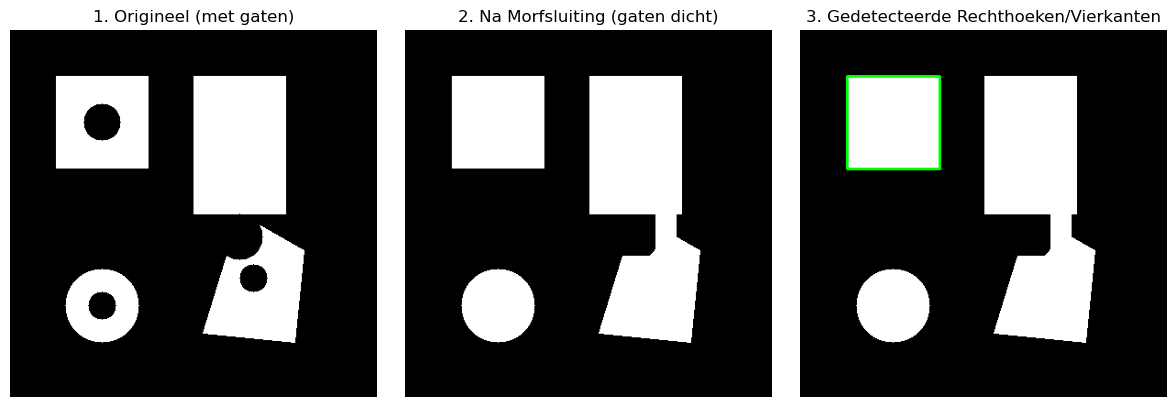

In [9]:
# === Stap 1: Maak een testafbeelding met rechthoeken en cirkels ===
img = np.zeros((400, 400), dtype=np.uint8)

# === Teken witte vormen ===
cv2.rectangle(img, (50, 50), (150, 150), 255, -1)       # Vierkant
cv2.rectangle(img, (200, 50), (300, 200), 255, -1)      # Rechthoek
cv2.circle(img, (100, 300), 40, 255, -1)                # Cirkel

# === Teken een onregelmatige vierhoek ===
pts = np.array([[250, 200], [320, 240], [310, 340], [210, 330]], np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(img, [pts], 255)

# === Voeg zwarte gaten toe in de vormen ===
cv2.circle(img, (100, 100), 20, 0, -1)
cv2.circle(img, (250, 225), 25, 0, -1)
cv2.circle(img, (265, 270), 15, 0, -1)
cv2.circle(img, (100, 300), 15, 0, -1)

# === Stap 2: Morfologische sluiting om gaten te vullen ===
kernel = np.ones((25, 40), np.uint8)
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# === Stap 3: Detecteer rechthoeken/vierkanten ===
output_detected = cv2.cvtColor(img_closed, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(img_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(cnt)

    if len(approx) == 4 and w * h > 1000:
        cv2.rectangle(output_detected, (x, y), (x + w, y + h), (0, 255, 0), 2)

# === Visualisatie: toon alle stappen ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.title("1. Origineel (met gaten)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_closed, cmap="gray", vmin=0, vmax=255)
plt.title("2. Na Morfsluiting (gaten dicht)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_detected, cv2.COLOR_BGR2RGB))
plt.title("3. Gedetecteerde Rechthoeken/Vierkanten")
plt.axis("off")

plt.tight_layout()
plt.show()

#### Uitleg

In de originele afbeelding zijn vier witte vormen te zien: een vierkant, een rechthoek, een cirkel en een onregelmatige vierhoek.  
In drie vorm is een zwart gat toegevoegd om een realistisch scenario te simuleren waarin er openingen of beschadigingen aanwezig zijn.

Na het toepassen van **morfologische sluiting** worden deze gaten effectief opgevuld.  
Hierdoor lijken de vormen weer volledig gesloten, wat gunstig is bij objectdetectie.

Er ontstaat echter een probleem: sommige vormen liggen dicht bij elkaar.  
Door de relatief grote kernel worden niet alleen de gaten gedicht, maar worden ook **twee afzonderlijke vormen onbedoeld met elkaar verbonden** (zoals de rechthoek en de vierhoek).

Gevolg: het algoritme ziet dit als **één grote onregelmatige vorm**, terwijl het er in werkelijkheid twee zijn.  
Omdat het systeem objecten classificeert op basis van hun **oppervlakte** en **aspect ratio**, wordt de oorspronkelijke logica hierdoor verstoord.  
De structuur van het beeld is veranderd en dus werkt de detectie minder nauwkeurig.


## Gevelobjectdetectie op meerdere afbeeldingen

In deze notebook voeren we een eenvoudige objectdetectie uit op gevelafbeeldingen. De pipeline herkent:
- het grootste object als **"Huis"**,
- objecten van middelgroot formaat als **"Deur"**,
- kleinere rechthoeken als **"Raam"**.

De resultaten worden per afbeelding getoond én automatisch opgeslagen in een lokale folder:
`Nest-Project/Old_school_AI_test_foto's\model_3`.

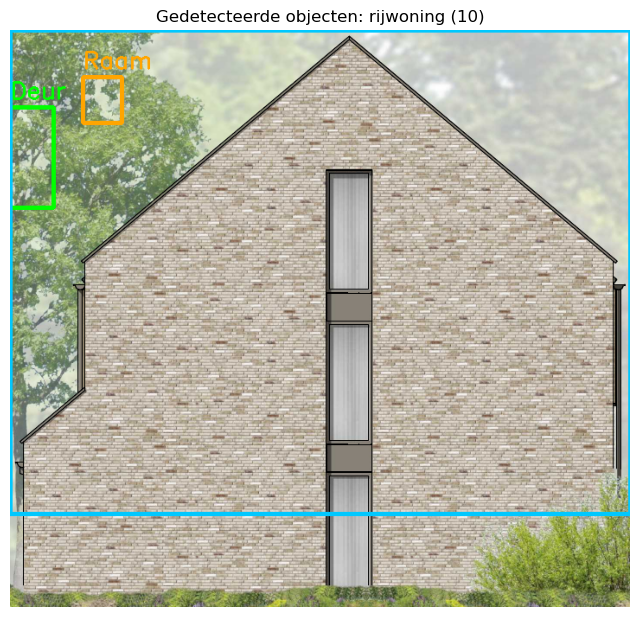

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_resultaat_rijwoning (10).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_rijwoning (10).json


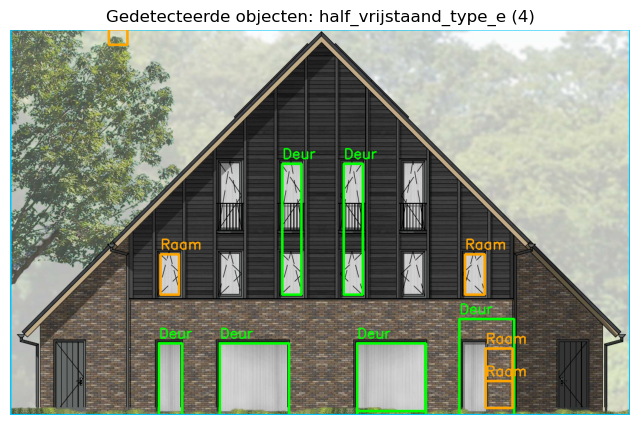

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_resultaat_half_vrijstaand_type_e (4).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_half_vrijstaand_type_e (4).json


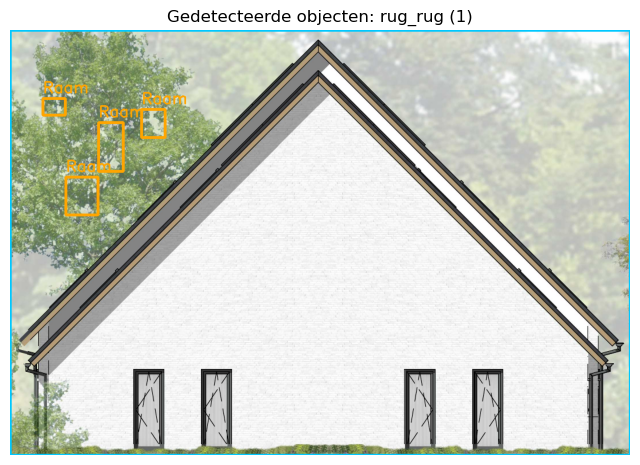

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_resultaat_rug_rug (1).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_rug_rug (1).json


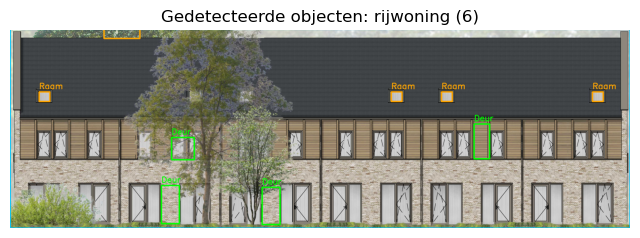

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_resultaat_rijwoning (6).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_3\detectie_rijwoning (6).json


In [10]:
# === Opslagpad configureren ===
save_folder = os.path.join(".", "Old_school_AI_test_foto's_na_detecteren", "model_3")
os.makedirs(save_folder, exist_ok=True)

# === Invoerpaden voor afbeeldingen ===
image_paths = [
    os.path.join("data_nest_uitgesneden", "rijwoning (10).png"),
    os.path.join("data_nest_uitgesneden", "half_vrijstaand_type_e (4).png"),
    os.path.join("data_nest_uitgesneden", "rug_rug (1).png"),
    os.path.join("data_nest_uitgesneden", "rijwoning (6).png")
]

# === Classificatieparameters ===
min_area_door = 5000
max_area_door = 20000
min_area_window = 1000
max_area_window = 5000

# Structuurelement voor morfologische sluiting
kernel = np.ones((50, 50), np.uint8)

# === Verwerking per afbeelding ===
for path in image_paths:
    filename = os.path.splitext(os.path.basename(path))[0]
    image = cv2.imread(path)

    if image is None:
        print(f"Fout bij inladen afbeelding: {path}")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(image_gray, (13, 13), 2.2)
    edges = cv2.Canny(blurred, 50, 150)

    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    output_image = image_rgb.copy()
    detected_objects = []

    if not contours:
        print(f"Geen contouren gevonden in afbeelding: {filename}")
        continue

    largest_contour = max(
        contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3]
    )

    # === Classificeer contouren ===
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        # aspect_ratio wordt hier niet meer gebruikt
        # aspect_ratio = w / h if h != 0 else 0

        if np.array_equal(contour, largest_contour):
            label = "Huis"
            color = (0, 200, 255)
        elif min_area_door < area < max_area_door:
            label = "Deur"
            color = (0, 255, 0)
        elif min_area_window < area < max_area_window:
            label = "Raam"
            color = (255, 165, 0)
        else:
            continue

        cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 3)
        cv2.putText(
            output_image, label, (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2
        )

        detected_objects.append({
            "label": label,
            "bounding_box": [int(x), int(y), int(w), int(h)],
        })

    # === Toon resultaat ===
    plt.figure(figsize=(8, 8))
    plt.imshow(output_image)
    plt.title(f"Gedetecteerde objecten: {filename}")
    plt.axis('off')
    plt.show()

    # === Opslaan van resultaten ===
    output_image_path = os.path.join(save_folder, f"detectie_resultaat_{filename}.jpg")
    output_json_path = os.path.join(save_folder, f"detectie_{filename}.json")

    cv2.imwrite(output_image_path, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

    with open(output_json_path, "w") as file:
        json.dump(detected_objects, file, indent=2)

    print(f"Opgeslagen: {output_image_path} en {output_json_path}")


De laatste celcode is bedoeld voor het valideren van 4 geveltekeningen. Ze zijn opgeslagen in de juiste map om later te vergelijken met de juiste resultaat-/gelabelde geveltekening.